# SNP ANALYSIS

In [1]:
import gzip
import pandas as pd
import numpy as np
import os

from multiprocessing import Pool
from matplotlib import pyplot as plt
from functools import reduce

from scipy import stats

# We use rpy2 for the prop.test and padjust in R
import rpy2
from rpy2 import robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr


from IPython.display import display, HTML

In [2]:
%load_ext rpy2.ipython

In [3]:
%matplotlib inline

In [4]:
rnaseq_one_cell_exps = [
"20210607-RNAseq-1cell-cross-A",
"20210607-RNAseq-1cell-cross-B",
"20210607-RNAseq-1cell-cross-C",
"20210607-RNAseq-1cell-cross-D"]

rnaseq_two_cell_exps = [
"20210607-RNAseq-2cell-cross-A",
"20210607-RNAseq-2cell-cross-B",
"20210607-RNAseq-2cell-cross-C",
"20210607-RNAseq-2cell-cross-D"
]

rnaseq_four_cell_exps = [
"20210607-RNAseq-4cell-cross-A",
#"20210607-RNAseq-4cell-cross-B",
"20210607-RNAseq-4cell-cross-C"
]

rnaseq_eight_cell_exps = [
"20210607-RNAseq-8cell-cross-A",
"20210607-RNAseq-8cell-cross-B",
"20210607-RNAseq-8cell-cross-C",
"20210607-RNAseq-8cell-cross-D"
]

rnaseq_gv_epxs = [
"20210607-RNAseq-GV-A",
"20210607-RNAseq-GV-B",
"20210607-RNAseq-GV-C",
"20210607-RNAseq-GV-D"
]

rnaseq_mii_exps = [
"20210607-RNAseq-MII-A",
"20210607-RNAseq-MII-B",
"20210607-RNAseq-MII-C",
"20210607-RNAseq-MII-D"
]

rnaseq_all_exps = rnaseq_one_cell_exps + rnaseq_two_cell_exps + \
                  rnaseq_four_cell_exps + rnaseq_eight_cell_exps + rnaseq_gv_epxs + rnaseq_mii_exps

In [5]:
riboseq_one_cell_exps = [
"20210513-ITP-1cell-cross-50-A",
"20210513-ITP-1cell-cross-50-B",
"20210513-ITP-1cell-cross-50-C",
"20210513-ITP-1cell-cross-50-D",
"20210513-ITP-1cell-cross-50-E"]
    
riboseq_two_cell_exps = [
"20210513-ITP-2cell-cross-50-B",
"20210513-ITP-2cell-cross-50-C",
"20210513-ITP-2cell-cross-50-F",
]

riboseq_four_cell_exps = [
"20210513-ITP-4cell-cross-50-B",
"20210513-ITP-4cell-cross-50-C",
"20210513-ITP-4cell-cross-50-D",
]
    
riboseq_eigth_cell_exps = [
"20210513-ITP-8cell-cross-50-A",
"20210513-ITP-8cell-cross-50-B",
"20210513-ITP-8cell-cross-50-C",
"20210513-ITP-8cell-cross-50-D",
]
    
    
riboseq_mii_exps = [
"20210301-ITP-MII-25-B",
"20210301-ITP-MII-50-A",
"20210301-ITP-MII-50-B",
"20210318-ITP-MII-50-B",
"20210614-ITP-MII-50-A",
#"20210614-ITP-MII-50-B",
"20210614-ITP-MII-50-C",
"20210614-ITP-MII-50-D",
"20210614-ITP-MII-50-E",
"20210614-ITP-MII-50-F",
]    
    
    
riboseq_gv_epxs = [
"20210614-ITP-GV-50-A",
"20210614-ITP-GV-50-B",
"20210614-ITP-GV-50-C",
"20210614-ITP-GV-50-D",
"20210614-ITP-GV-50-E",
"20210614-ITP-GV-50-F",
]

riboseq_all_exps = riboseq_one_cell_exps  + riboseq_two_cell_exps + \
                   riboseq_four_cell_exps + riboseq_eigth_cell_exps + \
                   riboseq_mii_exps       + riboseq_gv_epxs

## prop.test from R

Here we make sure that we are running the prop.test without error.
The following example is from the documentation of prop.test.

In [6]:
proptest = robjects.r('prop.test')
smokers  = robjects.IntVector([83, 90, 129, 70])
patients = robjects.IntVector([86, 93, 136, 82])
proptest(smokers, patients)

<rpy2.robjects.vectors.ListVector object at 0x7fbf557b08c8> [RTYPES.VECSXP]
R classes: ('htest',)
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., NULLType, StrSexpVe..., StrSexpVe..., StrSexpVe...]
  statistic: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7fbf557b0188> [RTYPES.REALSXP]
  parameter: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7fbf557b0ac8> [RTYPES.REALSXP]
  p.value: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7fbf55798b48> [RTYPES.REALSXP]
  estimate: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7fbf557b09c8> [RTYPES.REALSXP]
  null.value: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7fbf55fc1548> [RTYPES.NILSXP]
  conf.int: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7fbf55fc1548> [RTYPES.NILSXP]
  alternative: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x7fbf55798608> [RTYPES.STRSXP]
  method: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x7fbf55798448> [RTYPES.STRSXP]
  data.name: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x7fbf55798488> [RTYPES.STRSXP]

In [7]:
proptest(smokers, patients)[2][0]

0.005585476661627026

In [8]:
a = proptest(smokers, patients)

In [9]:
def extract_CDS(name_str):
    """
    Returns CDS boundaries from the transcript header
    """
    
    contents = name_str.split("|")
    
    for c in contents:
        if c.startswith("CDS"):
            boundaries = c.split(":")[1].split("-")
            return (int(boundaries[0]), int(boundaries[1]))
    
    print(name_str)
    raise ValueError
    
        

In [10]:
def get_df(snp_count_file):
    """
    Reads SNP cont file into a dataframe
    """
    
    count_df         = pd.read_csv(snp_count_file, sep = "\t")
    transcript_names = list( map( lambda x: x.split("|")[4], count_df["transcript"]) )

    boundaries       = list( map(extract_CDS, count_df["transcript"])  )

    start_positions  = list( map(lambda x: x[0], boundaries ) )
    stop_positions   = list( map(lambda x: x[1], boundaries ) )

    snp_total = count_df["A"] + count_df["C"] + count_df["G"] +  count_df["T"]

    count_df["transcript"] = transcript_names
    count_df["snp_total"]  = snp_total
    count_df["CDS_start"]  = start_positions
    count_df["CDS_stop"]   = stop_positions


    count_df.sort_values(by = ['snp_total'], ascending=False, inplace=True)
    
    return count_df

In [11]:
def get_ref_alt_counts(count_df):
    """
    Extracts the reference (maternal) and alternative (paternal) 
    counts from the dataframes
    """
    
    ref_count   = 0
    alt_count   = 0
    total_count = 0
    
    cds_ref_count   = 0
    cds_alt_count   = 0
    cds_total_count = 0

    for index, row in count_df.iterrows():
        total_count += row["A"] + row["C"] + row["G"] + row["T"]
        ref_count   += row[ row["REF"] ]
        alt_count   += row[ row["ALT"] ]
        
        if row["position"] >= row["CDS_start"] and\
           row["position"] <= row["CDS_stop"]:
                cds_total_count += row["A"] + row["C"] + row["G"] + row["T"]
                cds_ref_count   += row[ row["REF"] ]
                cds_alt_count   += row[ row["ALT"] ]            

        
    return {"ref_count":     ref_count,     "alt_count": alt_count,         "total_count": total_count,
            "cds_ref_count": cds_ref_count, "cds_alt_count": cds_alt_count, "cds_total_count": cds_total_count}

## RNA-Seq SNP Calls

In [12]:
rnaseq_experiment_dfs = dict()

for e in rnaseq_all_exps:
    this_file = os.path.join("snp_counts_rnaseq", e + ".tsv.gz")
    rnaseq_experiment_dfs[e] = get_df(this_file)

In [13]:
rnaseq_reference_alt_counts = dict()

with Pool(4) as p:
    rnaseq_counts_array = p.map( get_ref_alt_counts, [ rnaseq_experiment_dfs[e] for e in rnaseq_all_exps ] )
    
for i in range(len(rnaseq_all_exps)):
    rnaseq_reference_alt_counts[rnaseq_all_exps[i]] = rnaseq_counts_array[i]
    


In [14]:
for e in rnaseq_all_exps:
    print(e)
    print(rnaseq_reference_alt_counts[e])

20210607-RNAseq-1cell-cross-A
{'ref_count': 179914, 'alt_count': 314, 'total_count': 180540, 'cds_ref_count': 179914, 'cds_alt_count': 314, 'cds_total_count': 180540}
20210607-RNAseq-1cell-cross-B
{'ref_count': 180976, 'alt_count': 373, 'total_count': 181700, 'cds_ref_count': 180976, 'cds_alt_count': 373, 'cds_total_count': 181700}
20210607-RNAseq-1cell-cross-C
{'ref_count': 227455, 'alt_count': 450, 'total_count': 228431, 'cds_ref_count': 227455, 'cds_alt_count': 450, 'cds_total_count': 228431}
20210607-RNAseq-1cell-cross-D
{'ref_count': 223828, 'alt_count': 443, 'total_count': 224721, 'cds_ref_count': 223828, 'cds_alt_count': 443, 'cds_total_count': 224721}
20210607-RNAseq-2cell-cross-A
{'ref_count': 120936, 'alt_count': 7890, 'total_count': 129112, 'cds_ref_count': 120936, 'cds_alt_count': 7890, 'cds_total_count': 129112}
20210607-RNAseq-2cell-cross-B
{'ref_count': 141596, 'alt_count': 7723, 'total_count': 149630, 'cds_ref_count': 141596, 'cds_alt_count': 7723, 'cds_total_count': 14

In [15]:
def calculate_ref_alt_percentages(count_dict):
    ref_percentage = (count_dict["ref_count"] / count_dict["total_count"] ) * 100
    alt_percentage = (count_dict["alt_count"] / count_dict["total_count"] ) * 100
    
    cds_ref_percentage = (count_dict["cds_ref_count"] / count_dict["cds_total_count"] ) * 100
    cds_alt_percentage = (count_dict["cds_alt_count"] / count_dict["cds_total_count"] ) * 100
    
    return {"ref_percentage": ref_percentage, "alt_percentage" : alt_percentage,
           "cds_ref_percentage": cds_ref_percentage, "cds_alt_percentage" : cds_alt_percentage}

In [16]:
rnaseq_reference_alt_percentages = dict()

for e in rnaseq_all_exps:
    rnaseq_reference_alt_percentages[e] = calculate_ref_alt_percentages(rnaseq_reference_alt_counts[e])

In [17]:
for e in rnaseq_all_exps:
    print(e)
    print("Alt: {:.1f}    Ref: {:.1f}".format( rnaseq_reference_alt_percentages[e]["cds_alt_percentage"],
                                       rnaseq_reference_alt_percentages[e]["cds_ref_percentage"]))

20210607-RNAseq-1cell-cross-A
Alt: 0.2    Ref: 99.7
20210607-RNAseq-1cell-cross-B
Alt: 0.2    Ref: 99.6
20210607-RNAseq-1cell-cross-C
Alt: 0.2    Ref: 99.6
20210607-RNAseq-1cell-cross-D
Alt: 0.2    Ref: 99.6
20210607-RNAseq-2cell-cross-A
Alt: 6.1    Ref: 93.7
20210607-RNAseq-2cell-cross-B
Alt: 5.2    Ref: 94.6
20210607-RNAseq-2cell-cross-C
Alt: 5.0    Ref: 94.8
20210607-RNAseq-2cell-cross-D
Alt: 9.0    Ref: 90.7
20210607-RNAseq-4cell-cross-A
Alt: 47.0    Ref: 52.8
20210607-RNAseq-4cell-cross-C
Alt: 48.9    Ref: 50.9
20210607-RNAseq-8cell-cross-A
Alt: 46.8    Ref: 53.1
20210607-RNAseq-8cell-cross-B
Alt: 48.5    Ref: 51.3
20210607-RNAseq-8cell-cross-C
Alt: 49.2    Ref: 50.6
20210607-RNAseq-8cell-cross-D
Alt: 48.8    Ref: 51.0
20210607-RNAseq-GV-A
Alt: 0.2    Ref: 99.7
20210607-RNAseq-GV-B
Alt: 0.2    Ref: 99.6
20210607-RNAseq-GV-C
Alt: 0.3    Ref: 99.6
20210607-RNAseq-GV-D
Alt: 0.1    Ref: 99.7
20210607-RNAseq-MII-A
Alt: 0.3    Ref: 99.5
20210607-RNAseq-MII-B
Alt: 0.2    Ref: 99.6
202106

In [18]:
for e in rnaseq_all_exps:
    print(e)
    print("Alt: {:.1f}    Ref: {:.1f}".format( rnaseq_reference_alt_percentages[e]["alt_percentage"],
                                       rnaseq_reference_alt_percentages[e]["ref_percentage"]))

20210607-RNAseq-1cell-cross-A
Alt: 0.2    Ref: 99.7
20210607-RNAseq-1cell-cross-B
Alt: 0.2    Ref: 99.6
20210607-RNAseq-1cell-cross-C
Alt: 0.2    Ref: 99.6
20210607-RNAseq-1cell-cross-D
Alt: 0.2    Ref: 99.6
20210607-RNAseq-2cell-cross-A
Alt: 6.1    Ref: 93.7
20210607-RNAseq-2cell-cross-B
Alt: 5.2    Ref: 94.6
20210607-RNAseq-2cell-cross-C
Alt: 5.0    Ref: 94.8
20210607-RNAseq-2cell-cross-D
Alt: 9.0    Ref: 90.7
20210607-RNAseq-4cell-cross-A
Alt: 47.0    Ref: 52.8
20210607-RNAseq-4cell-cross-C
Alt: 48.9    Ref: 50.9
20210607-RNAseq-8cell-cross-A
Alt: 46.8    Ref: 53.1
20210607-RNAseq-8cell-cross-B
Alt: 48.5    Ref: 51.3
20210607-RNAseq-8cell-cross-C
Alt: 49.2    Ref: 50.6
20210607-RNAseq-8cell-cross-D
Alt: 48.8    Ref: 51.0
20210607-RNAseq-GV-A
Alt: 0.2    Ref: 99.7
20210607-RNAseq-GV-B
Alt: 0.2    Ref: 99.6
20210607-RNAseq-GV-C
Alt: 0.3    Ref: 99.6
20210607-RNAseq-GV-D
Alt: 0.1    Ref: 99.7
20210607-RNAseq-MII-A
Alt: 0.3    Ref: 99.5
20210607-RNAseq-MII-B
Alt: 0.2    Ref: 99.6
202106

In [19]:
rnaseq_experiment_dfs["20210607-RNAseq-4cell-cross-C"][:10]

,transcript,position,REF,ALT,A,C,G,T,snp_total,CDS_start,CDS_stop
68514,Rps19-203,303,C,T,1,521,1,616,1139,298,735
66330,Dppa3-201,290,A,C,691,403,1,0,1095,114,566
4478,Rps26-201,299,C,T,0,505,0,517,1022,270,617
66329,Dppa3-201,263,C,T,0,509,0,437,946,114,566
23498,Rpl15-202,275,A,G,441,0,474,0,915,120,734
6318,Rpl37a-201,166,C,A,448,432,0,1,881,32,310
38960,Fau-203,320,C,A,399,466,0,0,865,285,686
30524,Rpl35a-203,288,G,A,358,0,395,1,754,133,465
15654,Rpl38-203,359,G,A,336,0,368,2,706,204,416
54125,Rps8-201,353,C,A,385,312,0,1,698,183,809


In [20]:
def get_barplot_df(percentage_df, experiments, cds = False):
    """
    If cds=True, then only SNPS comig from CDS are taken
    if cds=False
    SNPs coming from the ENTIRE transcript are taken
    """
    
    reference_alt_percentages = percentage_df
    
    percentage_dict = {"Experiment": experiments,  "Paternal": [], "Maternal": [], "Other": []}
    
    if cds:
        key_prefix = "cds_"
    else:
        key_prefix = ""
            

    for e in experiments:
        print(e)
        percentage_dict["Maternal"].append( reference_alt_percentages[e][ key_prefix + "ref_percentage"]) 
        percentage_dict["Paternal"].append( reference_alt_percentages[e][key_prefix + "alt_percentage"]) 
        other = 100 - (reference_alt_percentages[e][key_prefix + "ref_percentage"] +\
                       reference_alt_percentages[e][key_prefix + "alt_percentage"])
        percentage_dict["Other"].append(other)

        print("Alt: {:.1f}    Ref: {:.1f} Other: {:.1f}".format( \
                                           reference_alt_percentages[e][key_prefix + "alt_percentage"],
                                           reference_alt_percentages[e][key_prefix + "ref_percentage"],
                                           other                ))
    
    
    p_df = pd.DataFrame(percentage_dict, index=experiments)
    
    return p_df

In [21]:
rnaseq_cds_barplot_df = \
    get_barplot_df(percentage_df = rnaseq_reference_alt_percentages, 
                   experiments   = rnaseq_all_exps, 
                   cds           = True)

20210607-RNAseq-1cell-cross-A
Alt: 0.2    Ref: 99.7 Other: 0.2
20210607-RNAseq-1cell-cross-B
Alt: 0.2    Ref: 99.6 Other: 0.2
20210607-RNAseq-1cell-cross-C
Alt: 0.2    Ref: 99.6 Other: 0.2
20210607-RNAseq-1cell-cross-D
Alt: 0.2    Ref: 99.6 Other: 0.2
20210607-RNAseq-2cell-cross-A
Alt: 6.1    Ref: 93.7 Other: 0.2
20210607-RNAseq-2cell-cross-B
Alt: 5.2    Ref: 94.6 Other: 0.2
20210607-RNAseq-2cell-cross-C
Alt: 5.0    Ref: 94.8 Other: 0.2
20210607-RNAseq-2cell-cross-D
Alt: 9.0    Ref: 90.7 Other: 0.3
20210607-RNAseq-4cell-cross-A
Alt: 47.0    Ref: 52.8 Other: 0.2
20210607-RNAseq-4cell-cross-C
Alt: 48.9    Ref: 50.9 Other: 0.2
20210607-RNAseq-8cell-cross-A
Alt: 46.8    Ref: 53.1 Other: 0.2
20210607-RNAseq-8cell-cross-B
Alt: 48.5    Ref: 51.3 Other: 0.2
20210607-RNAseq-8cell-cross-C
Alt: 49.2    Ref: 50.6 Other: 0.2
20210607-RNAseq-8cell-cross-D
Alt: 48.8    Ref: 51.0 Other: 0.2
20210607-RNAseq-GV-A
Alt: 0.2    Ref: 99.7 Other: 0.2
20210607-RNAseq-GV-B
Alt: 0.2    Ref: 99.6 Other: 0.2
2021

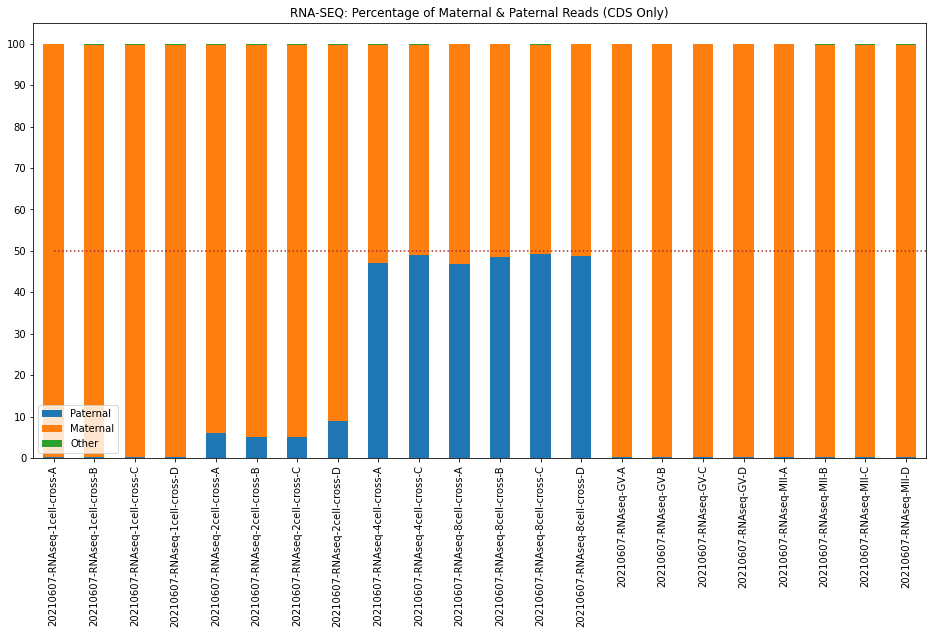

In [22]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]

fig  = rnaseq_cds_barplot_df.plot(kind    = "bar", 
                                  stacked = True, 
                                  title   = "RNA-SEQ: Percentage of Maternal & Paternal Reads (CDS Only)");

plt.hlines(50, xmin=0, xmax=len(rnaseq_all_exps), linestyle=':', color="brown" )
plt.yticks(list(range(0,110, 10) ))
fig.figure.savefig("paternal_maternal_read_percentages_rnaseq_cds.pdf");

## Ribosome Profiling SNP Calls

In [23]:
riboseq_experiment_dfs = dict()

for e in riboseq_all_exps:
    this_file = os.path.join("snp_counts_riboseq", e + ".tsv.gz")
    riboseq_experiment_dfs[e] = get_df(this_file)
    

riboseq_reference_alt_counts = dict()

with Pool(4) as p:
    riboseq_counts_array = p.map( get_ref_alt_counts, [ riboseq_experiment_dfs[e] for e in riboseq_all_exps ] )
    
for i in range(len(riboseq_all_exps)):
    riboseq_reference_alt_counts[riboseq_all_exps[i]] = riboseq_counts_array[i]

riboseq_reference_alt_percentages = dict()

for e in riboseq_all_exps:
    riboseq_reference_alt_percentages[e] = calculate_ref_alt_percentages(riboseq_reference_alt_counts[e])

In [24]:
for e in riboseq_all_exps:
    print(e)
    print("Alt: {:.1f}    Ref: {:.1f}".format( riboseq_reference_alt_percentages[e]["cds_alt_percentage"],
                                       riboseq_reference_alt_percentages[e]["cds_ref_percentage"]))

20210513-ITP-1cell-cross-50-A
Alt: 1.3    Ref: 97.0
20210513-ITP-1cell-cross-50-B
Alt: 0.9    Ref: 97.6
20210513-ITP-1cell-cross-50-C
Alt: 1.0    Ref: 96.8
20210513-ITP-1cell-cross-50-D
Alt: 1.2    Ref: 96.4
20210513-ITP-1cell-cross-50-E
Alt: 1.3    Ref: 96.0
20210513-ITP-2cell-cross-50-B
Alt: 11.8    Ref: 86.5
20210513-ITP-2cell-cross-50-C
Alt: 4.8    Ref: 93.0
20210513-ITP-2cell-cross-50-F
Alt: 7.1    Ref: 90.4
20210513-ITP-4cell-cross-50-B
Alt: 43.9    Ref: 52.7
20210513-ITP-4cell-cross-50-C
Alt: 43.5    Ref: 51.5
20210513-ITP-4cell-cross-50-D
Alt: 46.4    Ref: 51.6
20210513-ITP-8cell-cross-50-A
Alt: 46.0    Ref: 52.3
20210513-ITP-8cell-cross-50-B
Alt: 48.6    Ref: 49.6
20210513-ITP-8cell-cross-50-C
Alt: 47.6    Ref: 50.7
20210513-ITP-8cell-cross-50-D
Alt: 45.3    Ref: 52.9
20210301-ITP-MII-25-B
Alt: 1.0    Ref: 97.1
20210301-ITP-MII-50-A
Alt: 0.9    Ref: 97.8
20210301-ITP-MII-50-B
Alt: 0.8    Ref: 97.8
20210318-ITP-MII-50-B
Alt: 1.1    Ref: 97.4
20210614-ITP-MII-50-A
Alt: 1.0    Re

In [25]:
riboseq_barplot_cds_df = \
    get_barplot_df(percentage_df = riboseq_reference_alt_percentages, 
                   experiments   = riboseq_all_exps, 
                   cds           = True)

20210513-ITP-1cell-cross-50-A
Alt: 1.3    Ref: 97.0 Other: 1.8
20210513-ITP-1cell-cross-50-B
Alt: 0.9    Ref: 97.6 Other: 1.5
20210513-ITP-1cell-cross-50-C
Alt: 1.0    Ref: 96.8 Other: 2.2
20210513-ITP-1cell-cross-50-D
Alt: 1.2    Ref: 96.4 Other: 2.4
20210513-ITP-1cell-cross-50-E
Alt: 1.3    Ref: 96.0 Other: 2.6
20210513-ITP-2cell-cross-50-B
Alt: 11.8    Ref: 86.5 Other: 1.7
20210513-ITP-2cell-cross-50-C
Alt: 4.8    Ref: 93.0 Other: 2.2
20210513-ITP-2cell-cross-50-F
Alt: 7.1    Ref: 90.4 Other: 2.5
20210513-ITP-4cell-cross-50-B
Alt: 43.9    Ref: 52.7 Other: 3.4
20210513-ITP-4cell-cross-50-C
Alt: 43.5    Ref: 51.5 Other: 4.9
20210513-ITP-4cell-cross-50-D
Alt: 46.4    Ref: 51.6 Other: 2.0
20210513-ITP-8cell-cross-50-A
Alt: 46.0    Ref: 52.3 Other: 1.7
20210513-ITP-8cell-cross-50-B
Alt: 48.6    Ref: 49.6 Other: 1.7
20210513-ITP-8cell-cross-50-C
Alt: 47.6    Ref: 50.7 Other: 1.7
20210513-ITP-8cell-cross-50-D
Alt: 45.3    Ref: 52.9 Other: 1.8
20210301-ITP-MII-25-B
Alt: 1.0    Ref: 97.1 Oth

## Approximating the Error 

In GV and MII samples, we don't expect to see any reads coming from paternal genes. So, any such paternal reads are resulting from various sources of errors (e.g. mapping artifacts, sequencing or PCR errors etc.). We average the ratio of paternal reads in GV and MII samples to approximate error rate in ribosome profiling experiments in general.

In [26]:
sum_of_paternal_rates = 0

for e in riboseq_mii_exps + riboseq_gv_epxs:
    sum_of_paternal_rates += riboseq_barplot_cds_df.loc[e]["Paternal"]

ribo_error_rate = sum_of_paternal_rates / len(riboseq_mii_exps + riboseq_gv_epxs)
print("Error rate in ribosome profiling is %{:.2f}".format(ribo_error_rate))

Error rate in ribosome profiling is %1.06


In [27]:
riboseq_barplot_cds_df

,Experiment,Paternal,Maternal,Other
20210513-ITP-1cell-cross-50-A,20210513-ITP-1cell-cross-50-A,1.256003,96.983130,1.760867
20210513-ITP-1cell-cross-50-B,20210513-ITP-1cell-cross-50-B,0.932685,97.556772,1.510543
20210513-ITP-1cell-cross-50-C,20210513-ITP-1cell-cross-50-C,1.015572,96.750169,2.234259
20210513-ITP-1cell-cross-50-D,20210513-ITP-1cell-cross-50-D,1.171606,96.388697,2.439697
20210513-ITP-1cell-cross-50-E,20210513-ITP-1cell-cross-50-E,1.323877,96.028369,2.647754
20210513-ITP-2cell-cross-50-B,20210513-ITP-2cell-cross-50-B,11.798689,86.523720,1.677591
20210513-ITP-2cell-cross-50-C,20210513-ITP-2cell-cross-50-C,4.806034,93.017241,2.176724
20210513-ITP-2cell-cross-50-F,20210513-ITP-2cell-cross-50-F,7.081090,90.438897,2.480013
20210513-ITP-4cell-cross-50-B,20210513-ITP-4cell-cross-50-B,43.879685,52.678141,3.442175
20210513-ITP-4cell-cross-50-C,20210513-ITP-4cell-cross-50-C,43.549352,51.525424,4.925224


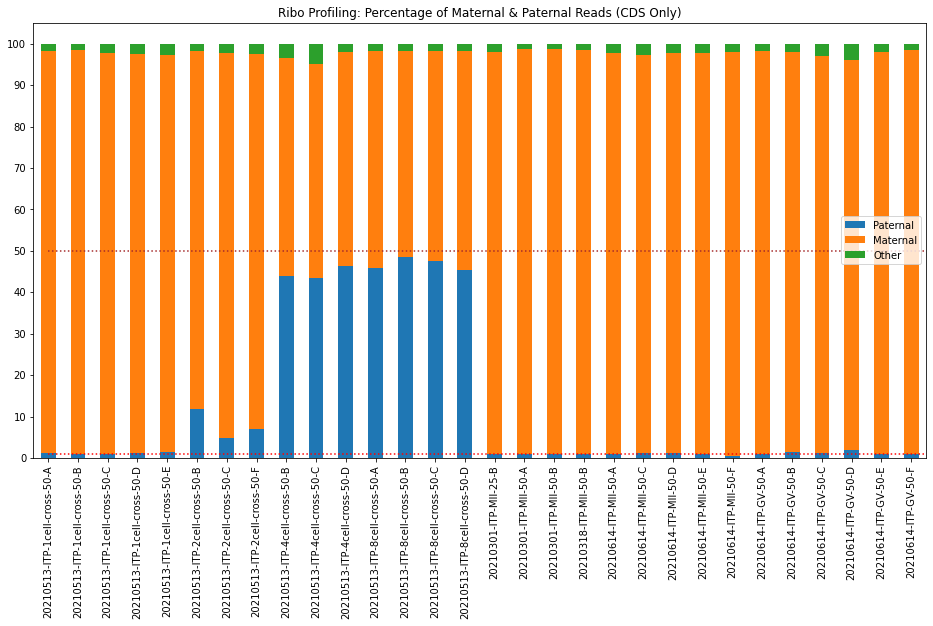

In [28]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]

fig  = riboseq_barplot_cds_df.plot(kind    = "bar", 
                                  stacked = True, 
                                  title   = "Ribo Profiling: Percentage of Maternal & Paternal Reads (CDS Only)");

plt.hlines(50, xmin=0, xmax=len(riboseq_all_exps), linestyle=':', color="brown" )
plt.hlines(1, xmin=0, xmax=len(riboseq_all_exps), linestyle=':', color="red" )
plt.yticks(list(range(0,110, 10) ))
fig.figure.savefig("paternal_maternal_read_percentages_riboseq_cds.pdf");

## Aggregating SNP Counts

We sum SNPs accross replicates

In [29]:
def add_two_snp_dfs(df_1, df_2):
    """
    This is the helper function to add dataframes
    
    Adds two dataframes and produces one that is compatible with other SNP dataframes
    (Have the same column names)
    """
    
    index_col_name = "trans_pos"
    
    zipped_df1_transcripts_df1_positions = zip( df_1["transcript"], df_1["position"] )
    zipped_df2_transcripts_df2_positions = zip( df_2["transcript"], df_2["position"] )
    
    df1_index_vec = list( map( lambda x: str(x[0]) + "_" + str(x[1]), zipped_df1_transcripts_df1_positions ) )
    df2_index_vec = list( map( lambda x: str(x[0]) + "_" + str(x[1]), zipped_df2_transcripts_df2_positions ) )
    
    df_1_indexed = df_1.copy()
    df_2_indexed = df_2.copy()
    
    df_1_indexed[index_col_name] = df1_index_vec
    df_2_indexed[index_col_name] = df2_index_vec
    
    df_1_indexed.set_index(index_col_name, inplace = True)
    df_2_indexed.set_index(index_col_name, inplace = True)
    
    merged_df = df_1_indexed.merge( df_2_indexed, on = ["trans_pos"] )
    
    df_dict = {
        #"trnas_pos":  merged_df.index,
        "transcript": merged_df["transcript_x"],
        "position":   merged_df["position_x"],
        "REF":        merged_df["REF_x"],
        "ALT":        merged_df["ALT_x"],
        "A":          np.add(merged_df["A_x"] , merged_df["A_y"]),
        "C":          np.add(merged_df["C_x"] , merged_df["C_y"]),
        "G":          np.add(merged_df["G_x"] , merged_df["G_y"]),
        "T":          np.add(merged_df["T_x"] , merged_df["T_y"]),
        "snp_total":  np.add(merged_df["snp_total_x"] , merged_df["snp_total_y"]),
        "CDS_start":  merged_df["CDS_start_x"],
        "CDS_stop":  merged_df["CDS_stop_x"]     
    }
    
    result_df = pd.DataFrame.from_dict(df_dict)
    
    return (result_df)


##############################################################################


def add_snp_dfs(df_list):
    """
    THIS IS THE MAIN FUNCTION TO CALL!!!
    Adds a list of dataframes containing SNPS
    """
    result_df =  reduce( lambda x, y : add_two_snp_dfs(x,y), df_list  )
    result_df.sort_values(by = ['snp_total'], ascending=False, inplace=True)
    return result_df

In the follwoing several cells, we do a quick sanity check for the above two functions.

In [30]:
add_two_snp_dfs( riboseq_experiment_dfs[riboseq_one_cell_exps[0]], riboseq_experiment_dfs[riboseq_one_cell_exps[1]] )

,transcript,position,REF,ALT,A,C,G,T,snp_total,CDS_start,CDS_stop
trans_pos,,,,,,,,,,,
Spin1-201_848,Spin1-201,848,C,G,0,320,2,1,323,261,1049
Zbed3-202_471,Zbed3-202,471,T,C,0,0,0,217,217,174,860
Zbed3-202_707,Zbed3-202,707,A,G,218,0,0,0,218,174,860
E330034G19Rik-203_257,E330034G19Rik-203,257,A,C,125,0,0,0,125,56,1111
Zbed3-202_320,Zbed3-202,320,T,G,8,2,10,130,150,174,860
...,...,...,...,...,...,...,...,...,...,...,...
Gpd1-201_825,Gpd1-201,825,T,C,0,0,0,0,0,94,1143
Gpd1-201_508,Gpd1-201,508,C,T,0,0,0,0,0,94,1143
Gpd1-201_462,Gpd1-201,462,C,T,0,0,0,0,0,94,1143


In [31]:
riboseq_experiment_dfs[riboseq_one_cell_exps[1]]

,transcript,position,REF,ALT,A,C,G,T,snp_total,CDS_start,CDS_stop
21047,Spin1-201,848,C,G,0,181,2,1,184,261,1049
22358,Zbed3-202,707,A,G,118,0,0,0,118,174,860
22356,Zbed3-202,471,T,C,0,0,0,93,93,174,860
22354,Zbed3-202,320,T,G,4,2,6,78,90,174,860
83783,AU022751-201,452,G,C,3,1,64,0,68,98,1504
...,...,...,...,...,...,...,...,...,...,...,...
29009,Gpd1-201,825,T,C,0,0,0,0,0,94,1143
29008,Gpd1-201,508,C,T,0,0,0,0,0,94,1143
29007,Gpd1-201,462,C,T,0,0,0,0,0,94,1143
29006,Smarcd1-201,1699,G,A,0,0,0,0,0,194,1741


In [32]:
add_snp_dfs( (riboseq_experiment_dfs[riboseq_one_cell_exps[0]], 
              riboseq_experiment_dfs[riboseq_one_cell_exps[1]])  )

,transcript,position,REF,ALT,A,C,G,T,snp_total,CDS_start,CDS_stop
trans_pos,,,,,,,,,,,
Spin1-201_848,Spin1-201,848,C,G,0,320,2,1,323,261,1049
Zbed3-202_707,Zbed3-202,707,A,G,218,0,0,0,218,174,860
Zbed3-202_471,Zbed3-202,471,T,C,0,0,0,217,217,174,860
Zbed3-202_320,Zbed3-202,320,T,G,8,2,10,130,150,174,860
E330034G19Rik-203_257,E330034G19Rik-203,257,A,C,125,0,0,0,125,56,1111
...,...,...,...,...,...,...,...,...,...,...,...
Itga11-201_2659,Itga11-201,2659,G,A,0,0,0,0,0,120,3686
Itga11-201_2966,Itga11-201,2966,C,T,0,0,0,0,0,120,3686
Itga11-201_3035,Itga11-201,3035,A,C,0,0,0,0,0,120,3686


In [33]:
riboseq_snp_total_one_cell   = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_one_cell_exps] )
riboseq_snp_total_two_cell   = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_two_cell_exps] )
riboseq_snp_total_four_cell  = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_four_cell_exps] )
riboseq_snp_total_eight_cell = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_eigth_cell_exps] )


riboseq_snp_total_mii = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_mii_exps] )
riboseq_snp_total_gv  = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_gv_epxs] )


In [34]:
rnaseq_snp_total_one_cell   = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_one_cell_exps] )
rnaseq_snp_total_two_cell   = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_two_cell_exps] )
rnaseq_snp_total_four_cell  = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_four_cell_exps] )
rnaseq_snp_total_eight_cell = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_eight_cell_exps] )


rnaseq_snp_total_mii = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_mii_exps] )
rnaseq_snp_total_gv  = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_gv_epxs] )

In [35]:
riboseq_snp_total_two_cell

,transcript,position,REF,ALT,A,C,G,T,snp_total,CDS_start,CDS_stop
trans_pos,,,,,,,,,,,
Zbed3-202_471,Zbed3-202,471,T,C,0,1,0,543,544,174,860
Zbed3-202_707,Zbed3-202,707,A,G,454,0,0,0,454,174,860
Zbed3-202_320,Zbed3-202,320,T,G,18,6,5,361,390,174,860
Spin1-201_848,Spin1-201,848,C,G,3,292,0,2,297,261,1049
Ankrd26-201_1877,Ankrd26-201,1877,C,A,0,212,0,0,212,170,5215
...,...,...,...,...,...,...,...,...,...,...,...
Zfp202-201_392,Zfp202-201,392,C,T,0,0,0,0,0,216,2141
Zfp202-201_1808,Zfp202-201,1808,T,C,0,0,0,0,0,216,2141
Zfp202-201_1988,Zfp202-201,1988,T,C,0,0,0,0,0,216,2141


We add the paternal / maternal counts ratios to our dataframes

In [36]:
def find_maternal_ratio(snp_df):
    maternal_ratios      = list()
    maternal_count       = list()
    paternal_count       = list()
    mat_pat_count        = list()
    
    for i, e in snp_df.iterrows():
        
        maternal_nuc  = e["REF"]
        paternal_nuc  = e["ALT"]
        mat_pat_total = e[maternal_nuc] + e[paternal_nuc]
        
        # Avoid division by 0
        if mat_pat_total == 0:
            mat_pat_total = 1
            
        maternal_ratio = e[maternal_nuc] / mat_pat_total
        
        mat_pat_count.append(mat_pat_total)
        maternal_ratios.append(maternal_ratio)
        maternal_count.append(e[maternal_nuc])
        paternal_count.append(e[paternal_nuc])
        
    snp_df["maternal_count"] = maternal_count 
    snp_df["paternal_count"] = paternal_count 
    snp_df["mat_pat_total"]  = mat_pat_count 
    snp_df["maternal_ratio"] = maternal_ratios
    
    

In [37]:
find_maternal_ratio(riboseq_snp_total_two_cell)
riboseq_snp_total_two_cell

,transcript,position,REF,ALT,A,C,G,T,snp_total,CDS_start,CDS_stop,maternal_count,paternal_count,mat_pat_total,maternal_ratio
trans_pos,,,,,,,,,,,,,,,
Zbed3-202_471,Zbed3-202,471,T,C,0,1,0,543,544,174,860,543,1,544,0.998162
Zbed3-202_707,Zbed3-202,707,A,G,454,0,0,0,454,174,860,454,0,454,1.000000
Zbed3-202_320,Zbed3-202,320,T,G,18,6,5,361,390,174,860,361,5,366,0.986339
Spin1-201_848,Spin1-201,848,C,G,3,292,0,2,297,261,1049,292,0,292,1.000000
Ankrd26-201_1877,Ankrd26-201,1877,C,A,0,212,0,0,212,170,5215,212,0,212,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zfp202-201_392,Zfp202-201,392,C,T,0,0,0,0,0,216,2141,0,0,1,0.000000
Zfp202-201_1808,Zfp202-201,1808,T,C,0,0,0,0,0,216,2141,0,0,1,0.000000
Zfp202-201_1988,Zfp202-201,1988,T,C,0,0,0,0,0,216,2141,0,0,1,0.000000


In [38]:
find_maternal_ratio( riboseq_snp_total_one_cell )
find_maternal_ratio( riboseq_snp_total_two_cell ) 
find_maternal_ratio( riboseq_snp_total_four_cell ) 
find_maternal_ratio( riboseq_snp_total_eight_cell )

find_maternal_ratio( riboseq_snp_total_mii )
find_maternal_ratio( riboseq_snp_total_gv ) 

In [39]:
find_maternal_ratio( rnaseq_snp_total_one_cell )
find_maternal_ratio( rnaseq_snp_total_two_cell ) 
find_maternal_ratio( rnaseq_snp_total_four_cell ) 
find_maternal_ratio( rnaseq_snp_total_eight_cell ) 

find_maternal_ratio( rnaseq_snp_total_mii )
find_maternal_ratio( rnaseq_snp_total_gv )

## Proportionality Test

In R
```
prop.test( paternal, total )
```

Note that the above test tells us whether `paternal_ribo / total_ribo` is significantly different than
`paternal_rna / total_rna`.

In [82]:
def perform_prop_test(df_1, df_2, error_threshold = 0.01):
    """
    Decide whether paternal  ratios differ between df_1 and df_2
    """
    
    pvalues        = []
    conf_midpoints = []

    merged_df = df_1.merge(df_2, on = "trans_pos")
    
    for i, e in merged_df.iterrows():
        #print(i, e)
        
        # Mark insufficient counts with p-val 10 and exclude them from the test
        if e["maternal_count_x"]+ e["paternal_count_x"] < 10  or\
           e["maternal_count_y"] + e["paternal_count_y"] < 10 :
            pvalues.append(10)
            conf_midpoints.append(10)
            continue
        
        
        if e["maternal_count_x"]+ e["maternal_count_y"] == 0 or\
           e["paternal_count_x"] + e["paternal_count_y"] == 0 :
            
            #print("detected zero at", i)
            pvalues.append(10)
            conf_midpoints.append(10)
            continue
            
        if e["paternal_count_x"] <=2 and e["paternal_count_y"] <= 2:
            pvalues.append(10)
            conf_midpoints.append(10)
            continue
        
        r_paternal_counts = robjects.IntVector([ e["paternal_count_x"], e["paternal_count_y"] ])
        r_total_counts    = robjects.IntVector([ e["paternal_count_x"] + e["maternal_count_x"], 
                                                 e["paternal_count_y"] + e["maternal_count_y"] ])
        
        proptest_result = proptest(r_paternal_counts, r_total_counts)
        result_dict     = dict(proptest_result.items())
        conf_int        = result_dict["conf.int"]
        mid_point_conf  = (conf_int[0] + conf_int[1]) / 2
        
        
        if conf_int[1] < 0 and error_threshold > (-1) * conf_int[1]:
            this_p_val = 5
        elif (error_threshold > conf_int[0]):
            this_p_val = 5
        else:
            this_p_val = proptest_result[2][0]
        
        
        pvalues.append(this_p_val)
        conf_midpoints.append(mid_point_conf)

        
    result_dict = { #"trans_pos" : merged_df["trans_pos"],
                    "p_val":      pvalues,
                    "conf_mid":   conf_midpoints,
                    "maternal_x": merged_df["maternal_count_x"],
                    "paternal_x": merged_df["paternal_count_x"],
                    "maternal_y": merged_df["maternal_count_y"],
                    "paternal_y": merged_df["paternal_count_y"]}
    
    
    
    result_df =  pd.DataFrame.from_dict( result_dict )
    
    return result_df

## Transcript Level SNPs

We aggregate paternal & paternal counts of transcripts. Next, we determine transcripts chaning behavior ( in terms of paternal / maternal ratio). 

In [41]:
def get_transcript_level_counts(snp_df):
    result_dict = {}
    
    for g in snp_df["transcript"]:
        result_dict[g] = { "transcript": g, "maternal_count": 0, "paternal_count": 0 }
        #result_dict[g] = { "maternal_count": 0, "paternal_count": 0 }
        
    for i, e in snp_df.iterrows():
        
        g = e["transcript"]
        
        result_dict[g]["maternal_count"] += e["maternal_count"] 
        result_dict[g]["paternal_count"] += e["paternal_count"]
        
    result_df = pd.DataFrame.from_dict( result_dict ).transpose()
    result_df.index.rename("trans_pos", inplace = True)

    
    return result_df

In [42]:
riboseq_t_level_snp_total_gv         = get_transcript_level_counts(riboseq_snp_total_gv)
riboseq_t_level_snp_total_mii        = get_transcript_level_counts(riboseq_snp_total_mii )
riboseq_t_level_snp_total_one_cell   = get_transcript_level_counts(riboseq_snp_total_one_cell )
riboseq_t_level_snp_total_two_cell   = get_transcript_level_counts(riboseq_snp_total_two_cell )
riboseq_t_level_snp_total_four_cell  = get_transcript_level_counts(riboseq_snp_total_four_cell )
riboseq_t_level_snp_total_eight_cell = get_transcript_level_counts(riboseq_snp_total_eight_cell )


In [43]:
rnaseq_t_level_snp_total_mii        = get_transcript_level_counts(rnaseq_snp_total_mii )
rnaseq_t_level_snp_total_gv         = get_transcript_level_counts(rnaseq_snp_total_gv )
rnaseq_t_level_snp_total_one_cell   = get_transcript_level_counts(rnaseq_snp_total_one_cell )
rnaseq_t_level_snp_total_two_cell   = get_transcript_level_counts(rnaseq_snp_total_two_cell )
rnaseq_t_level_snp_total_four_cell  = get_transcript_level_counts(rnaseq_snp_total_four_cell )
rnaseq_t_level_snp_total_eight_cell = get_transcript_level_counts(rnaseq_snp_total_eight_cell )


In [83]:
proptest_t_level_gv_ribo_rna         = perform_prop_test( riboseq_t_level_snp_total_gv, rnaseq_t_level_snp_total_gv )
proptest_t_level_mii_ribo_rna        = perform_prop_test( riboseq_t_level_snp_total_mii, rnaseq_t_level_snp_total_mii )
proptest_t_level_one_cell_ribo_rna   = perform_prop_test( riboseq_t_level_snp_total_one_cell, rnaseq_t_level_snp_total_one_cell )
proptest_t_level_two_cell_ribo_rna   = perform_prop_test( riboseq_t_level_snp_total_two_cell, rnaseq_t_level_snp_total_two_cell )
proptest_t_level_four_cell_ribo_rna  = perform_prop_test( riboseq_t_level_snp_total_four_cell, rnaseq_t_level_snp_total_four_cell )
proptest_t_level_eight_cell_ribo_rna = perform_prop_test( riboseq_t_level_snp_total_eight_cell, rnaseq_t_level_snp_total_eight_cell )

## A closer look at the midpoints of confidence Intervals

We take a closer look at the midpoints of the 95% confidence intervals coming from prop test. Note that this interval is for the difference between the difference of the proportions of paternal and maternal ratios.

In [98]:
plt.rcParams["figure.figsize"] = (15,5)

def plot_midpoint_hist(prop_test_res_df, title = ""):
    this_df = prop_test_res_df
    mid_points = this_df[this_df["p_val"] < 10]["conf_mid"]
    mid_points.plot.hist(bins = 100)
    plt.vlines([-0.01, 0.01], ymin=0, ymax=10, color = "red")
    plt.vlines([-0.05, 0.05], ymin=0, ymax=10, color = "orange")
    plt.title(title)

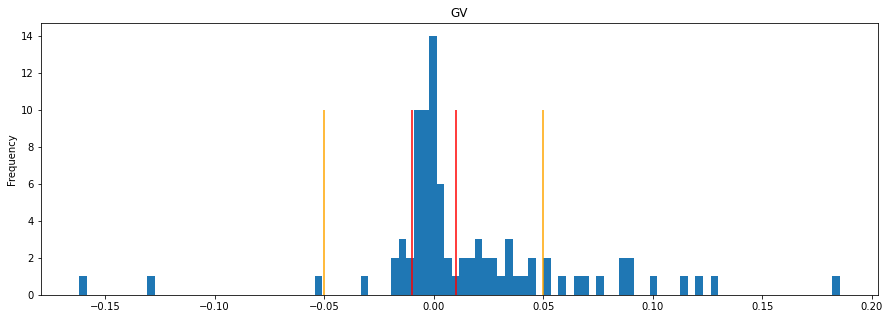

In [101]:
plot_midpoint_hist(proptest_t_level_gv_ribo_rna, title = "GV")


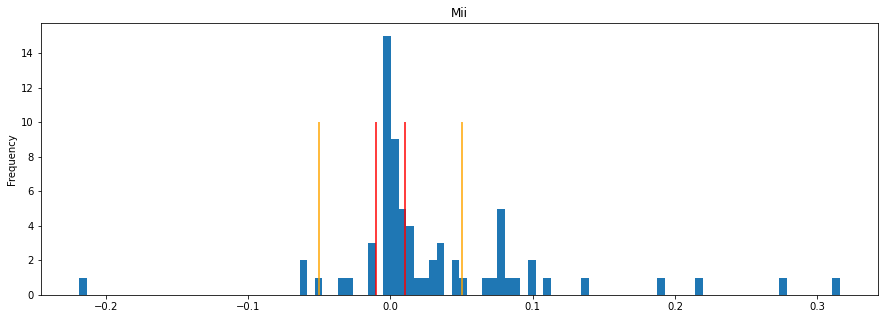

In [102]:
plot_midpoint_hist(proptest_t_level_mii_ribo_rna, title = "Mii")

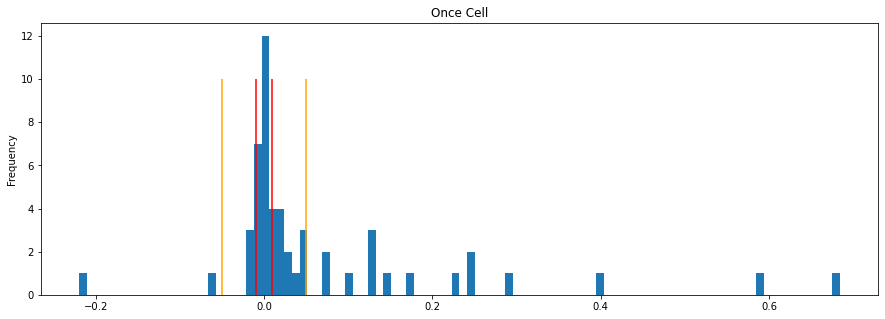

In [103]:
plot_midpoint_hist(proptest_t_level_one_cell_ribo_rna, title = "One Cell")

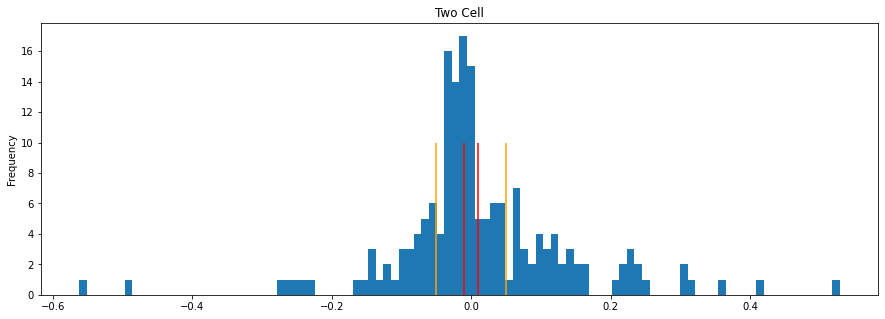

In [104]:
plot_midpoint_hist(proptest_t_level_two_cell_ribo_rna, title = "Two Cell")

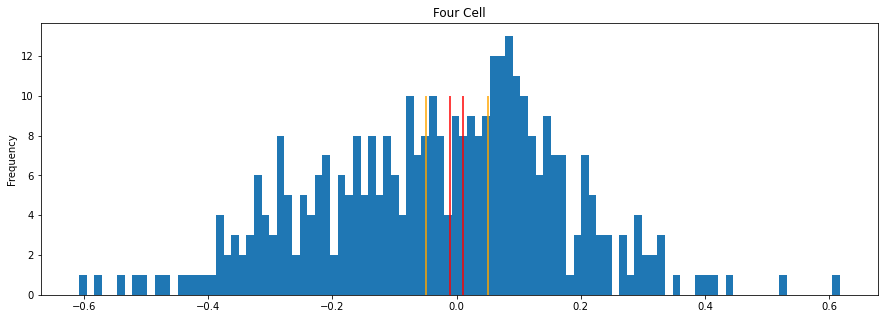

In [105]:
plot_midpoint_hist(proptest_t_level_four_cell_ribo_rna, title = "Four Cell")

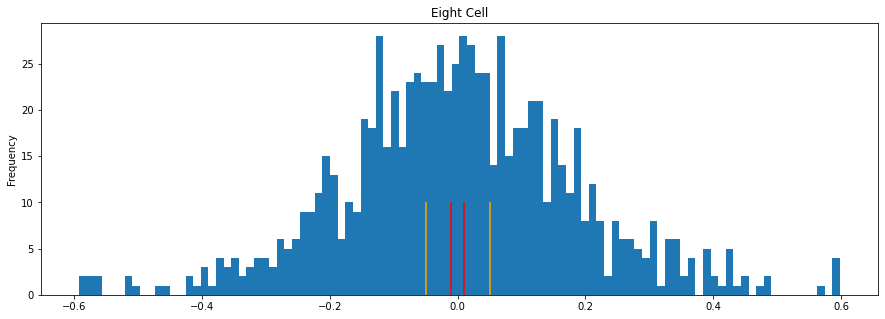

In [106]:
plot_midpoint_hist(proptest_t_level_eight_cell_ribo_rna, title = "Eight Cell")

In [47]:
padjust = robjects.r("p.adjust")


def filter_and_padjust_proptest_results( input_df , threshold = 2 ):
    
    #result_df = input_df[t_index]
    # exclude obvious cases marked with p values >= 5
    result_df = input_df[ input_df["p_val"] < 5 ]
    
    result_df = result_df[ np.logical_not(np.isclose(result_df["p_val"] , 1) ) ]
    
    
    
    p_values         = robjects.FloatVector( result_df["p_val"] )
    r_fdr_values     = padjust( p_values, method = "fdr" )
    result_df["fdr"] = [float(x) for x in r_fdr_values] 
    
    
    return result_df

In [107]:

filtered_proptest_t_level_gv_ribo_rna         = filter_and_padjust_proptest_results(proptest_t_level_gv_ribo_rna)
filtered_proptest_t_level_mii_ribo_rna        = filter_and_padjust_proptest_results(proptest_t_level_mii_ribo_rna)
filtered_proptest_t_level_one_cell_ribo_rna   = filter_and_padjust_proptest_results(proptest_t_level_one_cell_ribo_rna)
filtered_proptest_t_level_two_cell_ribo_rna   = filter_and_padjust_proptest_results(proptest_t_level_two_cell_ribo_rna)
filtered_proptest_t_level_four_cell_ribo_rna  = filter_and_padjust_proptest_results(proptest_t_level_four_cell_ribo_rna)
filtered_proptest_t_level_eight_cell_ribo_rna = filter_and_padjust_proptest_results(proptest_t_level_eight_cell_ribo_rna)

### MII

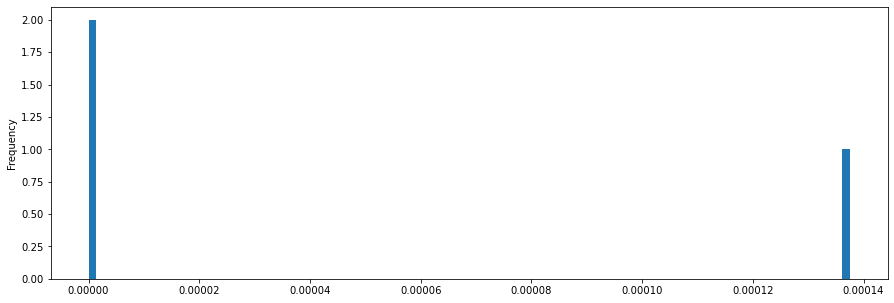

In [108]:
filtered_proptest_t_level_mii_ribo_rna["p_val"].plot.hist(bins=100);

In [50]:
filtered_proptest_t_level_mii_ribo_rna.sort_values(by="fdr")

,p_val,maternal_x,paternal_x,maternal_y,paternal_y,fdr
trans_pos,,,,,,
Zar1-201,3.454119e-18,105,9,1079,0,1.036236e-17
Ccdc47-201,8.201531e-13,13,6,191,0,1.230230e-12
Bmi1-201,1.374721e-04,20,18,448,110,1.374721e-04


### GV

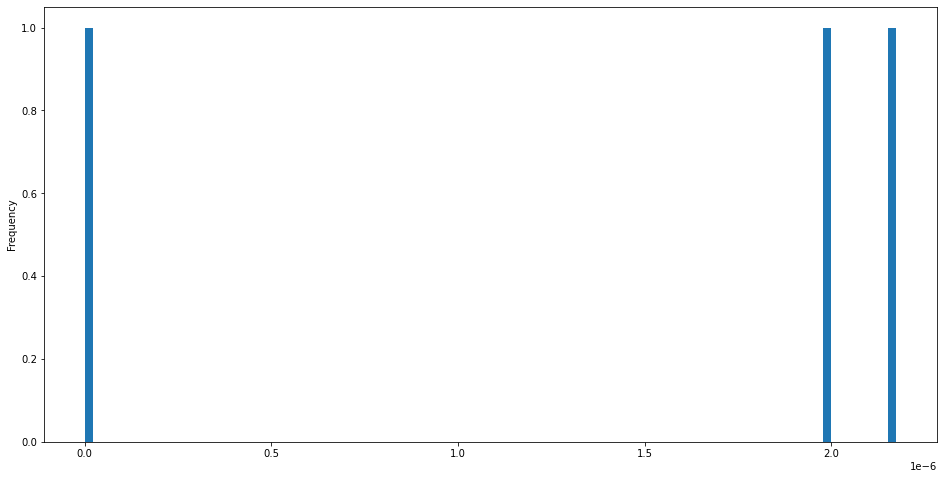

In [51]:
filtered_proptest_t_level_gv_ribo_rna["p_val"].plot.hist(bins=100);

In [52]:
filtered_proptest_t_level_gv_ribo_rna.sort_values(by="fdr")

,p_val,maternal_x,paternal_x,maternal_y,paternal_y,fdr
trans_pos,,,,,,
A430033K04Rik-202,1.159392e-33,72,7,2215,1,3.478175e-33
Parp12-201,2.174424e-06,97,7,397,0,2.174424e-06
Fbxw28-201,1.988816e-06,60,6,303,0,2.174424e-06


In [53]:
interesting_genes = dict()
FDR_THRESHOLD     = 0.05

### One Cell

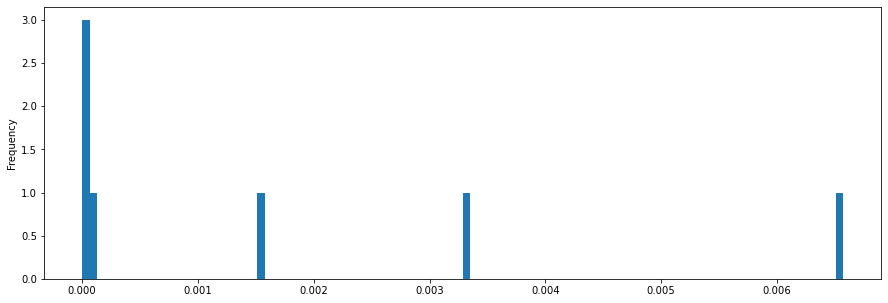

In [109]:
filtered_proptest_t_level_one_cell_ribo_rna["p_val"].plot.hist(bins=100);

In [55]:
one_cell_selected_entries = filtered_proptest_t_level_one_cell_ribo_rna[\
                                        filtered_proptest_t_level_one_cell_ribo_rna["fdr"] < FDR_THRESHOLD]\
                                            .sort_values(by="fdr")
one_cell_selected_entries

,p_val,maternal_x,paternal_x,maternal_y,paternal_y,fdr
trans_pos,,,,,,
Ccdc47-201,2.139852e-22,6,13,139,0,1.497896e-21
Rpa1-202,1.104555e-14,6,9,119,1,3.865942e-14
Epn2-213,1.432345e-06,12,5,97,0,3.342138e-06
H1f1-201,1.219490e-04,35,6,123,0,2.134107e-04
Nlrp4f-204,1.523225e-03,26,9,413,36,2.132515e-03
Pecam1-204,3.305210e-03,6,4,28,0,3.856078e-03
Bmi1-201,6.572609e-03,14,10,399,84,6.572609e-03


In [56]:
interesting_genes[1] = list( one_cell_selected_entries.index )

### Two Cell

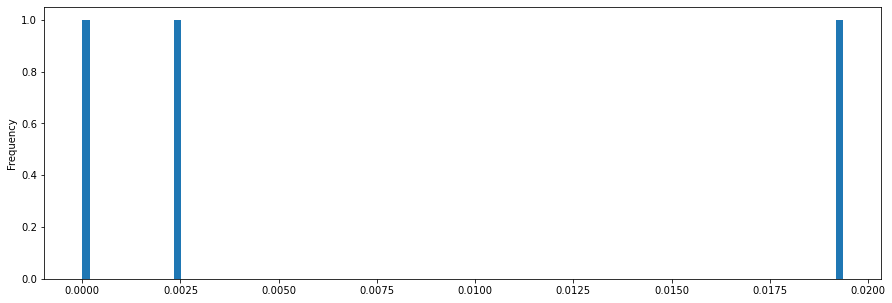

In [110]:

filtered_proptest_t_level_two_cell_ribo_rna["p_val"].plot.hist(bins=100);

In [58]:
two_cell_selected_entries = filtered_proptest_t_level_two_cell_ribo_rna[\
                                filtered_proptest_t_level_two_cell_ribo_rna["fdr"] < FDR_THRESHOLD]\
                                   .sort_values(by="fdr")

two_cell_selected_entries

,p_val,maternal_x,paternal_x,maternal_y,paternal_y,fdr
trans_pos,,,,,,
Bmi1-201,1.906544e-09,14,16,365,48,5.719632e-09
Dyrk3-201,2.345179e-03,1,13,21,14,3.517768e-03
Ccne2-207,1.936851e-02,6,7,49,11,1.936851e-02


In [59]:
interesting_genes[2] = list(two_cell_selected_entries.index)

### Four Cell

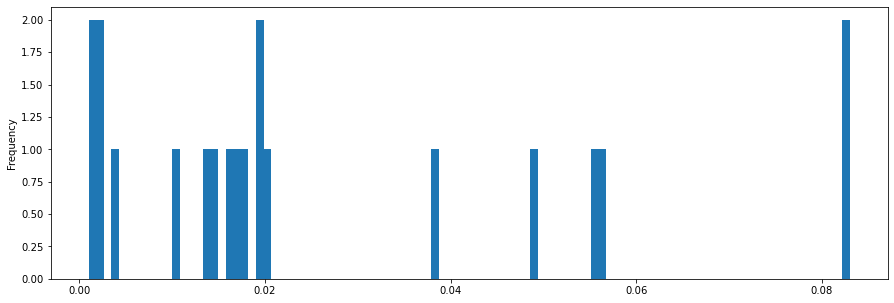

In [112]:
filtered_proptest_t_level_four_cell_ribo_rna["p_val"].plot.hist(bins=100);

In [113]:
four_cell_selected_entries = filtered_proptest_t_level_four_cell_ribo_rna[filtered_proptest_t_level_four_cell_ribo_rna["fdr"] < FDR_THRESHOLD].sort_values(by="fdr")
four_cell_selected_entries

,p_val,conf_mid,maternal_x,paternal_x,maternal_y,paternal_y,fdr
trans_pos,,,,,,,
Rps11-201,0.000987,0.217296,16,47,1435,1610,0.011534
Rpl28-201,0.001153,0.523810,0,12,132,120,0.011534
Baz1a-205,0.002120,0.399351,6,22,27,17,0.012287
Ncoa3-201,0.002457,0.617424,7,17,10,1,0.012287
Brca2-201,0.003691,0.210131,25,43,130,95,0.014765
Eef2-201,0.014625,0.146279,73,105,74,59,0.028746
Rps19-203,0.013634,0.223607,8,27,955,1157,0.028746
Nolc1-201,0.016024,0.159536,41,60,95,73,0.028746
Cdk1-201,0.017182,0.330808,4,14,73,59,0.028746


In [62]:
interesting_genes[4] = list( four_cell_selected_entries.index )
len(interesting_genes[4])

14

### Eight Cell

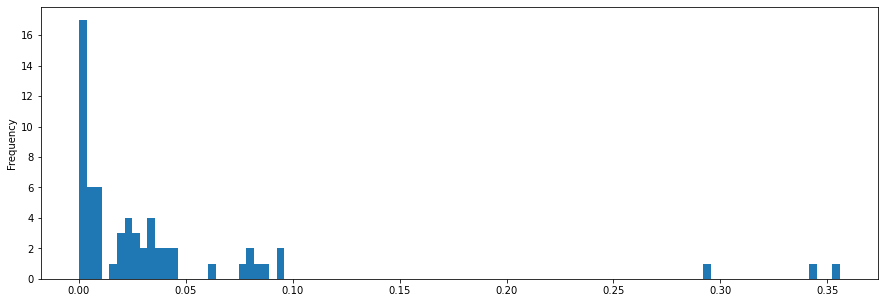

In [114]:
filtered_proptest_t_level_eight_cell_ribo_rna["p_val"].plot.hist(bins=100);

In [64]:
eight_cell_selected_entries = filtered_proptest_t_level_eight_cell_ribo_rna[\
                                filtered_proptest_t_level_eight_cell_ribo_rna["fdr"] < FDR_THRESHOLD].sort_values(by="fdr")
eight_cell_selected_entries[:60]

,p_val,maternal_x,paternal_x,maternal_y,paternal_y,fdr
trans_pos,,,,,,
Idh3g-201,4.362811e-27,11,10,263,0,2.748571e-25
Utp14a-201,1.065977e-14,7,4,214,0,3.357827e-13
Slc6a8-203,4.547391e-09,5,5,102,1,9.549522e-08
Ddx3x-201,4.302610e-07,11,16,36,0,6.776610e-06
Slc13a2-201,1.577287e-06,2,21,52,24,1.987381e-05
Huwe1-201,1.931803e-05,14,8,54,0,2.028393e-04
Tsen2-201,3.159634e-05,6,37,30,22,2.843670e-04
Tmppe-201,4.159355e-05,9,16,23,1,3.275492e-04
Tgoln1-201,6.596874e-04,0,11,49,33,4.617812e-03


In [65]:
interesting_genes[8] = list( eight_cell_selected_entries.index )

In [115]:
set_of_interesting_genes = set(interesting_genes[1] + interesting_genes[2] + interesting_genes[4] + interesting_genes[8])

In [116]:
len(set_of_interesting_genes)

68

In [117]:

ribo_transcript_snp_count_dfs = [riboseq_t_level_snp_total_gv, riboseq_t_level_snp_total_mii, 
                            riboseq_t_level_snp_total_one_cell, riboseq_t_level_snp_total_two_cell,
                            riboseq_t_level_snp_total_four_cell, riboseq_t_level_snp_total_eight_cell]

rna_transcript_snp_count_dfs = [rnaseq_t_level_snp_total_gv, rnaseq_t_level_snp_total_mii,
                                rnaseq_t_level_snp_total_one_cell, rnaseq_t_level_snp_total_two_cell,
                                rnaseq_t_level_snp_total_four_cell, rnaseq_t_level_snp_total_eight_cell]


def get_transcript_ratios(transcript):

    prefix = "paternal"
    ribo_paternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"] ) for x in ribo_transcript_snp_count_dfs ]
    prefix = "maternal"
    ribo_maternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in ribo_transcript_snp_count_dfs ]

    # Avoid division by 0
    for i ,v in enumerate(ribo_maternal_counts):
        if v == 0:
            ribo_maternal_counts[i] = 1
    
    prefix = "paternal"
    rna_paternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in rna_transcript_snp_count_dfs ]
    prefix = "maternal"
    rna_maternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in rna_transcript_snp_count_dfs ]

    # Avoid division by 0
    for i , v in enumerate(rna_maternal_counts):
        if v == 0:
            rna_maternal_counts[i] = 1
    
    ribo_ratios = np.divide( ribo_paternal_counts, ribo_maternal_counts )
    rna_ratios  = np.divide( rna_paternal_counts, rna_maternal_counts )
    
    result_dict = {
        "ribo_ratios"          : ribo_ratios,
        "rna_ratios"           : rna_ratios,
        "ribo_paternal_counts" : ribo_paternal_counts,
        "ribo_maternal_counts" : ribo_maternal_counts,
        "rna_paternal_counts"  : rna_paternal_counts,
        "rna_maternal_counts"  : rna_maternal_counts
    }
    
    return( result_dict )


In [69]:

def _plot_ratios( snp_ratio_and_counts, title = "Some Title" ):
    """
    Helper Function:
    Plots paternal / maternal ratios for ribosome profiling and RNA-Seq 
    Also, annotates the data points with the actual counts of the form (paternal, maternal)
    """

    fig, ax = plt.subplots()
    
    ax.plot(snp_ratio_and_counts["ribo_ratios"] , "o", color = "blue", label = "ribo")
    ax.plot(snp_ratio_and_counts["rna_ratios"] , "^", color = "orange", label = "rna")
    
    xpos = list(range(6))
    
    for i in range(6):
        ax.annotate( "{}, {}".format(snp_ratio_and_counts["ribo_paternal_counts"][i],
                                     snp_ratio_and_counts["ribo_maternal_counts"][i]) , 
                    (i, snp_ratio_and_counts["ribo_ratios"][i]),
                    textcoords="offset points",
                    xytext=(20,5),
                    ha = "center",
                   color = "blue")
        
        ax.annotate( "{}, {}".format(snp_ratio_and_counts["rna_paternal_counts"][i],
                                     snp_ratio_and_counts["rna_maternal_counts"][i]) , 
                    (i, snp_ratio_and_counts["rna_ratios"][i]),
                    textcoords="offset points",
                    xytext=(-20,5),
                    ha = "center",
                   color = "orange")

    #ax.legend(loc='upper right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    
    plt.title(title)

    #ax.set_ylim(bottom = min_val, top = max_val)

    plt.xticks(ticks = [0,1,2,3,4,5], labels = ["gv", "m2", "1", "2", "4", "8"])
    #plt.show()
    return fig

In [70]:
def plot_transcript_ratios(transcript):
    """
    Helper Function:
    Plots paternal / maternal ratios for ribosome profiling and RNA-Seq 
    Also, annotates the data points with the actual counts of the form (paternal, maternal)
    """
    
    snp_ratio_and_counts = get_transcript_ratios(transcript)
    return _plot_ratios( snp_ratio_and_counts, title = transcript )

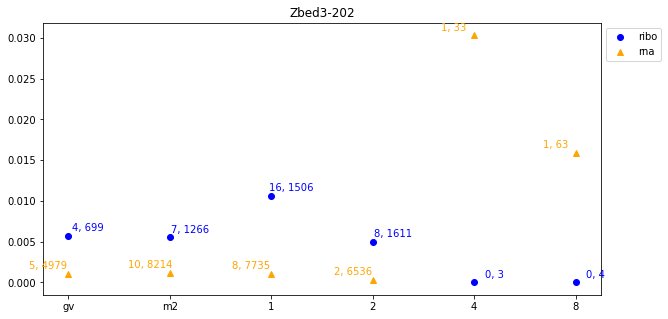

In [81]:
# Sample Plot
plt.rcParams["figure.figsize"] = (10,5)


plot_transcript_ratios(transcript = "Zbed3-202");

In [118]:
def get_mat_pat_snp_counts_from_df( this_df, transcript,):
    res_df = this_df.loc[ this_df["transcript"] == transcript ]
    res_df = res_df[ ["maternal_count", "paternal_count"] ]
    return  res_df

def display_transcript_snps(transcript):
    my_ribo_dfs = { "1 Cell": get_mat_pat_snp_counts_from_df(riboseq_snp_total_one_cell, transcript),
                    "2 Cell": get_mat_pat_snp_counts_from_df(riboseq_snp_total_two_cell, transcript),
                    "4 Cell": get_mat_pat_snp_counts_from_df(riboseq_snp_total_four_cell, transcript),
                    "8 Cell": get_mat_pat_snp_counts_from_df(riboseq_snp_total_eight_cell, transcript),
                  }
    
    my_rna_dfs =  { "1 Cell": get_mat_pat_snp_counts_from_df(rnaseq_snp_total_one_cell, transcript),
                    "2 Cell": get_mat_pat_snp_counts_from_df(rnaseq_snp_total_two_cell, transcript),
                    "4 Cell": get_mat_pat_snp_counts_from_df(rnaseq_snp_total_four_cell, transcript),
                    "8 Cell": get_mat_pat_snp_counts_from_df(rnaseq_snp_total_eight_cell, transcript),
                  }
    
    for k in my_ribo_dfs.keys():
        this_df = my_ribo_dfs[k].merge(my_rna_dfs[k], on="trans_pos", suffixes=("_ribo", "_rna"))
        display(HTML("<center>{}</center>".format(k)))
        display( HTML(this_df.to_html() ) )
        

In [119]:
def get_brief_transcript_info(transcript):
    print(transcript)
    display( plot_transcript_ratios(transcript) )
    display_transcript_snps(transcript)
    return 0

## PropTest Results: Raw

In [120]:
#mini_genes = 
exp_types  = ["mii", "1", "2", "4", "8"] 

df_dict = dict([ (x, {}) for x in exp_types ])

for g in set_of_interesting_genes:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict[e][g] = a["ribo_ratios"][i+1]
        
ribo_ratios_df = pd.DataFrame.from_dict(df_dict).transpose()
ribo_ratios_df.to_csv("./raw_proptest_ribo_ratios.csv")

In [121]:
exp_types  = ["mii", "1", "2", "4", "8"] 

df_dict = dict([ (x, {}) for x in exp_types ])

for g in set_of_interesting_genes:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict[e][g] = a["rna_ratios"][i+1]
        
rna_ratios_df = pd.DataFrame.from_dict(df_dict).transpose()
rna_ratios_df.to_csv("./raw_proptest_rna_ratios.csv")

In [125]:
ribo_ratios_df + 10

,Acsl4-201,Tsen2-201,Atp6v0a4-202,Pecam1-204,Mtf1-201,H1f1-201,Plk1-201,Dnajc21-201,Atg2a-201,Usp15-211,...,Nlrp4f-204,Rbm19-201,Eef2-201,Naalad2-204,Idh3g-201,Mat2a-201,Cth-201,Rpl28-201,Rpa1-202,Atg7-201
mii,10.000000,11.000000,10.00,10.166667,10.0,10.013333,10.000000,10.000000,10.000000,10.04,...,10.153846,10.0,10.000000,10.000000,10.000000,10.000,10.00,10.0,10.5,10.0
1,10.000000,11.000000,10.00,10.666667,10.0,10.171429,10.000000,10.000000,10.000000,10.00,...,10.346154,10.0,10.000000,10.000000,10.000000,10.000,10.00,10.0,11.5,10.0
2,10.000000,15.000000,10.00,10.500000,10.0,10.038911,10.000000,10.000000,10.000000,10.00,...,10.083333,10.0,10.833333,10.000000,10.000000,10.000,10.00,10.0,10.0,10.0
4,10.000000,10.000000,14.00,12.500000,10.0,11.133333,10.714286,11.250000,10.625000,10.00,...,10.000000,10.0,11.438356,11.750000,10.500000,10.875,11.00,22.0,10.0,11.0
8,10.454545,16.166667,13.75,11.500000,14.5,11.096774,13.400000,13.333333,12.307692,14.00,...,10.000000,12.0,10.828125,10.769231,10.909091,11.750,14.75,13.0,11.0,17.0


In [77]:
rna_ratios_df

,Acsl4-201,Tsen2-201,Atp6v0a4-202,Pecam1-204,Mtf1-201,H1f1-201,Plk1-201,Dnajc21-201,Atg2a-201,Usp15-211,...,Nlrp4f-204,Rbm19-201,Eef2-201,Naalad2-204,Idh3g-201,Mat2a-201,Cth-201,Rpl28-201,Rpa1-202,Atg7-201
mii,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.072581,0.111111,0.000000,0.000000,0.00000,0.000000,0.000000,0.076923,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.002519,0.000000,0.000000,0.000000,0.038462,0.001420,...,0.087167,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.008403,0.000000
2,0.000000,0.000000,0.028571,0.000000,0.030888,0.028037,0.268657,0.007752,0.166667,0.002045,...,0.088561,0.000000,0.179104,0.233333,0.75000,0.705882,0.039735,0.288889,0.125000,0.000000
4,1.384615,0.333333,0.636364,1.400000,1.000000,4.000000,0.972973,0.857143,2.000000,0.294118,...,0.000000,0.545455,0.797297,0.282051,1.16129,0.700000,1.947368,0.909091,2.000000,1.125000
8,0.000000,0.733333,0.581395,0.823529,0.597458,0.500000,0.861789,0.754545,0.882353,0.586207,...,0.000000,0.515152,1.010309,0.732283,0.00000,0.600897,1.645161,1.086614,0.333333,1.023256


In [144]:
pseudo_count = 10
ribo_to_rna_ratios = (ribo_ratios_df + pseudo_count) / ((rna_ratios_df ) + pseudo_count)
ribo_to_rna_ratios

,Acsl4-201,Tsen2-201,Atp6v0a4-202,Pecam1-204,Mtf1-201,H1f1-201,Plk1-201,Dnajc21-201,Atg2a-201,Usp15-211,...,Nlrp4f-204,Rbm19-201,Eef2-201,Naalad2-204,Idh3g-201,Mat2a-201,Cth-201,Rpl28-201,Rpa1-202,Atg7-201
mii,1.000000,1.100000,1.000000,1.016667,1.000000,1.001333,1.000000,1.000000,1.000000,1.004000,...,1.008068,0.989011,1.000000,1.000000,1.000000,1.000000,1.000000,0.992366,1.050000,1.000000
1,1.000000,1.100000,1.000000,1.066667,0.999748,1.017143,1.000000,1.000000,0.996169,0.999858,...,1.025675,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.149034,1.000000
2,1.000000,1.500000,0.997151,1.050000,0.996921,1.001084,0.973837,0.999225,0.983607,0.999796,...,0.999482,1.000000,1.064272,0.977199,0.930233,0.934066,0.996042,0.971922,0.987654,1.000000
4,0.878378,0.967742,1.316239,1.096491,0.909091,0.795238,0.976425,1.036184,0.885417,0.971429,...,1.000000,0.948276,1.059372,1.142768,0.940751,1.016355,0.920705,2.016667,0.833333,0.988764
8,1.045455,1.506211,1.299451,1.062500,1.368253,1.056836,1.233683,1.239786,1.130977,1.322476,...,1.000000,1.141210,0.983453,1.003443,1.090909,1.108397,1.266620,1.172585,1.064516,1.542194


In [145]:
ribo_to_rna_ratios.to_csv("./raw_proptest_ribo_to_rna_ratios.csv")

## Refining Gene Selection:

We exclude the genes having paternal reads in MII stage.

In [ ]:
genes_with_paternal_reads_in_mii = \
[ 
"Rps19-203",
"Rpa1-202",
"Ccdc47-201",
"Tsen2-201",
"Bmi1-201",
"Ddx3x-201",
"Huwe1-201",
"Pecam1-204",
"Nlrp4f-204",
"H1f1-201",
]

In [ ]:
refined_gene_selection = list()

for x in set_of_interesting_genes:
    if x not in genes_with_paternal_reads_in_mii:
        refined_gene_selection.append(x)

In [ ]:
refined_ribo_ratios_df        = ribo_ratios_df[refined_gene_selection]
refined_rna_ratios_df         = rna_ratios_df[refined_gene_selection]
refined_ribo_to_rna_ratios_df = ribo_to_rna_ratios[ refined_gene_selection ]

refined_ribo_ratios_df.to_csv("./refined_ribo_ratios.csv")
refined_rna_ratios_df.to_csv("./refined_rna_ratios.csv")
refined_ribo_to_rna_ratios_df.to_csv("./refined_ribo_to_rna_ratios.csv")

In [ ]:
!pwd

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

for g in set_of_interesting_genes:
    #get_brief_transcript_info( g )
    print(g)
    display( plot_transcript_ratios(g) );
    print("----------------------------------------------------")
    print("----------------------------------------------------")

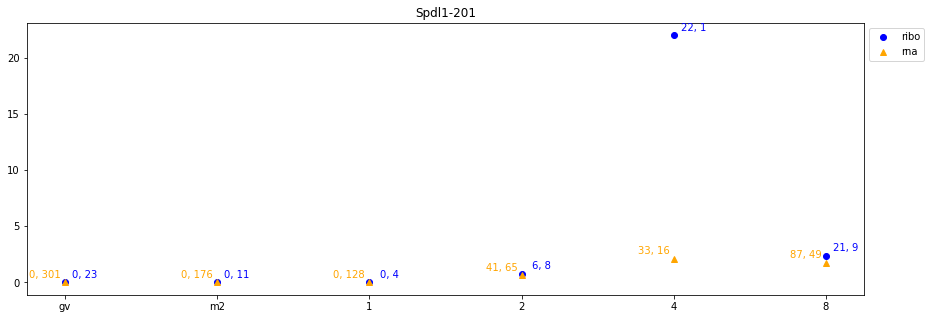

In [137]:
plot_transcript_ratios("Spdl1-201");